# Import Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

# Data Transformations

In [ ]:
data_transforms = {
    'training_set': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
   'test_set': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Import dataset from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the base directory for your data
data_dir = '/content/drive/MyDrive/Animals/Animals_Imges_5_classes'

# Define the path to your training data
train_data_path = '/content/drive/MyDrive/Animals/Animals_Imges_5_classes/Training_set'
test_data_path = '/content/drive/MyDrive/Animals/Animals_Imges_5_classes/Test_set'

# Check if the directory exists
if not os.path.isdir(train_data_path):
    print("The directory does not exist.")
else:
    print("The directory exists.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The directory exists.


# Create data loaders

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x.lower()])  # Re-add .lower() to match keys in data_transforms
                   for x in ['Training_set', 'Test_set']}  # Use uppercase 'T' and 'S' to match folder names

# Use torch.utils.data.DataLoader
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers=4)
                for x in ['Training_set', 'Test_set']}  # Use uppercase 'T' and 'S' here as well
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training_set', 'Test_set']}
print(dataset_sizes)

# Print classes names
class_names = image_datasets['Training_set'].classes  # Use uppercase 'T'
print(class_names)

{'Training_set': 12668, 'Test_set': 2065}
['Bird', 'Cat', 'Dog', 'Fish', 'Rabbit']


# Load pre-trained model resnet-18

In [ ]:
model = models.resnet18(pretrained=True)

# freeze all layers except final classification layer
for name, param in model.named_parameters():
  if "fc" in name: # unfreeze the final classification layer
    param.requires_grad = True
  else:
      param.requires_grad = False

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # use all parameters

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training the model

In [ ]:
# training loop
num_epochs = 5
for epoch in range(num_epochs):
  for phase in ['Training_set', 'Test_set']:
        if phase == 'Training_set':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in data_loaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'Training_set'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'Training_set':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
print("Training is Completed!!")

Training_set Loss: 0.8172 Acc: 0.7251
Test_set Loss: 0.1568 Acc: 0.9458
Training_set Loss: 0.7128 Acc: 0.7541
Test_set Loss: 0.1535 Acc: 0.9530
Training_set Loss: 0.7066 Acc: 0.7531
Test_set Loss: 0.1183 Acc: 0.9676
Training_set Loss: 0.7106 Acc: 0.7513
Test_set Loss: 0.1784 Acc: 0.9356
Training_set Loss: 0.6883 Acc: 0.7603
Test_set Loss: 0.1144 Acc: 0.9676
Training is Completed!!


In [ ]:
# save the model
torch.save(model.state_dict(), 'Animals Classification.pth')

In [ ]:
import os
print(os.getcwd())

/content


# Classification on unseen images

In [ ]:
import os
import torch
from torchvision import models, transforms
from PIL import Image

# load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('Animals Classification.pth'))
model.eval()

# create a new model with correct final layer
new_model = models.resnet18(pretrained = True)
new_model.fc = nn.Linear(new_model.fc.in_features, 4)

# copy the weights and biases from the loaded model to new model
new_model.fc.weight.data = model.fc.weight.data[0:4]
new_model.fc.bias.data = model.fc.bias.data[0:4]

# load and preprocess the unseen data
image_path = '/content/drive/MyDrive/Animals/Animals_Imges_5_classes/Test_set/fish/1633810793211_Giant Gurmee Fish and Marble Catfish 6 for sale.jpg'

# Check if the file exists in the current directory
if not os.path.exists(image_path):
    print(f"Error: The file '{image_path}' does not exist in the current directory.")
    # You might want to handle this error, e.g., by asking the user for a different path or exiting the script.
else:
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)

    # move the model to the GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    new_model = new_model.to(device)

In [ ]:
# perform inference
with torch.no_grad():
    output = model(input_batch)

# get the predicted class
_, predicted_class = output.max(1)
print("Predicted class:", predicted_class)

# map the predicted class to the class name
class_names = ['Bird', 'cat', 'dog', 'fish', 'rabbit']
predicted_class_name = class_names[predicted_class.item()]
print("Predicted class name:", predicted_class_name)

Predicted class: tensor([3])
Predicted class name: fish


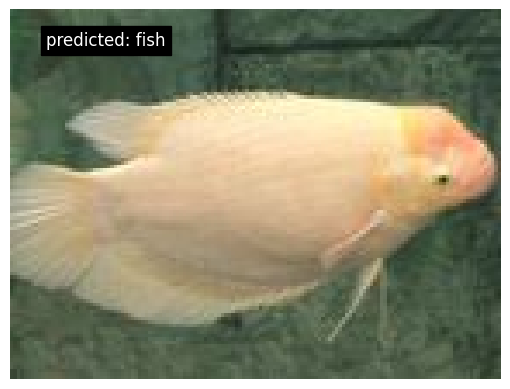

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# display the image with predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='black')
plt.show()